In [59]:
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import inspect

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

import models
from models import get_accuracy

#### **Load and process dataset**

In [60]:
dataset = 'movielens'
use_gpu = 6

train_edges = np.load('data/' + dataset + '/train_edges.npy')
test_edges = np.load('data/' + dataset + '/test_edges.npy')

user_list_train = train_edges[:, 0]
user_list_test = test_edges[:, 0]
item_list_train = train_edges[:, 1]
item_list_test = test_edges[:, 1]
rating_list_train = train_edges[:, 2].astype('float32')
rating_list_test = test_edges[:, 2].astype('float32')

n_users = max(user_list_train.max(), user_list_test.max()) + 1 
n_items = max(item_list_train.max(), item_list_test.max()) + 1
n_samples_train = len(rating_list_train)
n_samples_test = len(rating_list_test)

print('n_users:', n_users)
print('n_items:', n_items)
print('n_samples_train:', n_samples_train)
print('n_samples_test:', n_samples_test)

if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

users = torch.tensor(user_list_train, device = device)
items = torch.tensor(item_list_train, device = device)
ratings = torch.tensor(rating_list_train, device = device, requires_grad = True)

users_test = torch.tensor(user_list_test, device = device)
items_test = torch.tensor(item_list_test, device = device)
ratings_test = torch.tensor(rating_list_test, device = device)

ratings_np = ratings.detach().to('cpu').int().numpy()
ratings_test_np = ratings_test.detach().to('cpu').int().numpy()

n_users: 943
n_items: 1682
n_samples_train: 159619
n_samples_test: 40381


#### **Function to test any model**

In [24]:
def test_model(algorithm, n_users, n_items, n_factors=16, T = 50, optim = 'adam', lr = 0.1, seed = 0, device = 'cpu'):
    
    torch.manual_seed(seed)
    model = getattr(models, algorithm)(n_users, n_items, n_factors).to(device)
    
    if optim == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    elif optim == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr = lr)
    else:
        raise ValueError('optimizer must be adam or sgd')

    loss_fn = torch.nn.BCELoss(reduction = 'mean')
    
    train_auc = []
    valid_auc = []

    for _ in tqdm(range(T)):
        model.eval()
        with torch.no_grad():
            y_hat = model(users, items).detach().to('cpu').numpy()
            y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
            train_auc.append(roc_auc_score(ratings_np, y_hat))
            valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))
        
        model.train()
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward(retain_graph = True)
        optimizer.step()
    
    model.eval()
    loss = loss_fn(y_hat, ratings)
    meta_grad = torch.autograd.grad(loss, ratings)[0]
    print('max meta grad: ', meta_grad.max().item())
    print('min meta grad: ', meta_grad.min().item())

    with torch.no_grad():
        y_hat = model(users, items)
        y_hat_test = model(users_test, items_test)
        print('Training accuracy: ', get_accuracy(y_hat, ratings))
        print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
        print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
        print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))
        print('Max validatio accuracy: ', max(valid_auc))
        print('Max validation AUC: ', max(valid_auc))

    plt.plot(train_auc, label = 'Training AUC')
    plt.plot(valid_auc, label = 'Validation AUC')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('AUROC')
    plt.title('AUROC vs epochs for {} algorithm'.format(algorithm))
    plt.show()

#### **Check available models**

In [32]:
[m[0] for m in inspect.getmembers(models, inspect.isclass) if m[1].__module__ == 'models']

['CF', 'CFD', 'GMF', 'GMFB', 'GMFD', 'MLP']

In [69]:
model = getattr(models, 'GMF')(n_users, n_items, n_factors).to(device)
model(users, items).shape

torch.Size([159619, 1])

#### **MLP algorithm**

In [39]:
test_model('MLP', n_users, n_items, n_factors = 16, T = 100, optim = 'adam', lr = 0.1, seed = 0, device = device)

  0%|          | 0/100 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([159619])) that is different to the input size (torch.Size([159619, 1])) is deprecated. Please ensure they have the same size.

#### **GMF algorithm with user-item bias**

100%|██████████| 200/200 [00:12<00:00, 15.71it/s]


max meta grad:  0.0002295246667927131
min meta grad:  -inf
Training accuracy:  0.8737744092941284
Training AUC:  0.9485473606331404
Validation accuracy:  0.8142938613891602
Validation AUC:  0.8965669103576861
Max validatio accuracy:  0.8982597149305726
Max validation AUC:  0.8982597149305726


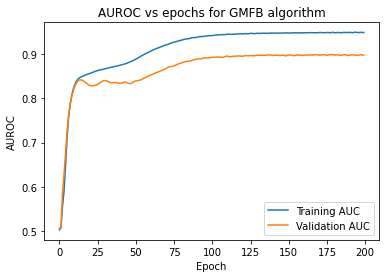

In [26]:
test_model('GMFB', n_users, n_items, n_factors = 8, T = 200, optim = 'adam', lr = 0.1, seed = 0, device = device)

#### **Test the model**

#### **Test GMFD**

max meta grad:  0.00016304224845953286
min meta grad:  -inf
Training accuracy:  0.8734987378120422
Training AUC:  0.9473852879023851
Validation accuracy:  0.812684178352356
Validation AUC:  0.8909770460232569


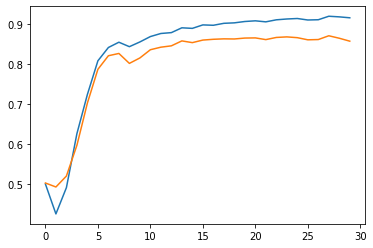

In [31]:
n_factors = 16
T = 30
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = GMFD(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing GMF**

max meta grad:  0.0003827007603831589
min meta grad:  -inf
Training accuracy:  0.9159999489784241
Training AUC:  0.9753514114878358
Validation accuracy:  0.7791040539741516
Validation AUC:  0.8561287338697806


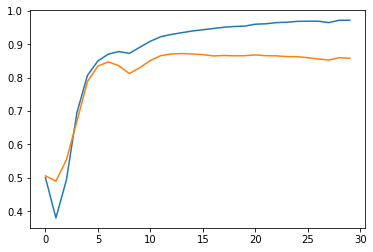

In [32]:
n_factors = 16
T = 30
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = GMF(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing CFD**

max meta grad:  0.00024571456015110016
min meta grad:  -inf
Training accuracy:  0.8331401348114014
Training AUC:  0.9145737757319232
Validation accuracy:  0.7985934019088745
Validation AUC:  0.8782287424562092


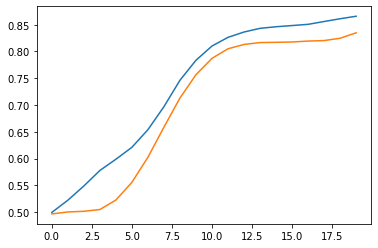

In [15]:
n_factors = 16
T = 20
seed = 50
lr = 0.3

torch.manual_seed(seed)
model = CFD(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).reshape(ratings.shape).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).reshape(ratings_test.shape).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items).reshape(ratings.shape)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items).reshape(ratings.shape)
    y_hat_test = model(users_test, items_test).reshape(ratings_test.shape)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing CF**

max meta grad:  inf
min meta grad:  -inf
Training accuracy:  0.9508579969406128
Training AUC:  0.9899306658900513
Validation accuracy:  0.769842267036438
Validation AUC:  0.8300272594573377


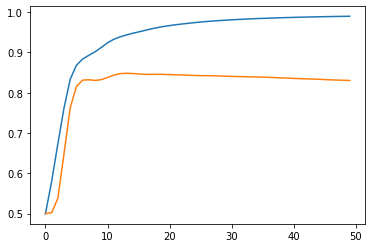

In [36]:
n_factors = 16
T = 50
seed = 50
lr = 0.5

torch.manual_seed(seed)
model = CF(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.5)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

model.train()
for t in list(range(T)):
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

#### **Testing MLP**

max meta grad:  8.789499406702816e-05
min meta grad:  -5.762612636317499e-05
Training accuracy:  0.8600855469703674
Training AUC:  0.9366130102425301
Validation accuracy:  0.8025308847427368
Validation AUC:  0.8832110593199547


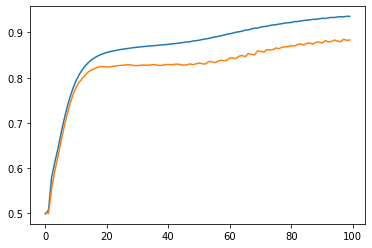

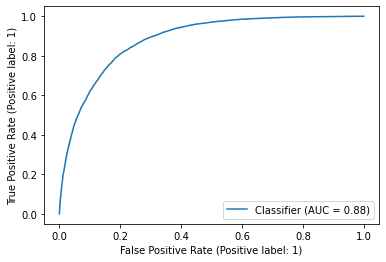

In [34]:
n_factors = 16
T = 100
seed = 50
lr = 0.05

torch.manual_seed(seed)
model = MLP(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

for t in list(range(T)):
    model.eval()
    with torch.no_grad():
        y_hat = model(users, items).reshape(ratings.shape).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).reshape(ratings_test.shape).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))

    model.train()
    y_hat = model(users, items).reshape(ratings.shape)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items).reshape(ratings.shape)
    y_hat_test = model(users_test, items_test).reshape(ratings_test.shape)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()
RocCurveDisplay.from_predictions(ratings_test_np, y_hat_test.detach().to('cpu').numpy())
plt.show()

#### **Testing GMFB**

100%|██████████| 200/200 [00:12<00:00, 16.41it/s]


max meta grad:  0.0002259853936266154
min meta grad:  -inf
Training accuracy:  0.8838233351707458
Training AUC:  0.9561807178562906
Validation accuracy:  0.8176617622375488
Validation AUC:  0.8969587225847603
Max validatio accuracy:  0.897947497669398
Max validation AUC:  0.897947497669398


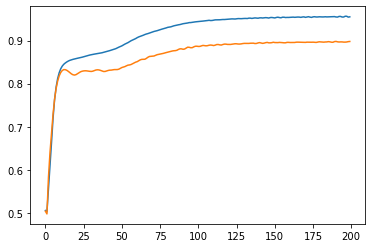

In [7]:
n_factors = 10
T = 200
seed = 50
lr = 0.1

torch.manual_seed(seed)
model = GMFB(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = lr)
loss_fn = torch.nn.BCELoss(reduction = 'mean')

train_auc = []
valid_auc = []

for _ in tqdm(range(T)):
    model.eval()
    with torch.no_grad():
        y_hat = model(users, items).detach().to('cpu').numpy()
        y_hat_test = model(users_test, items_test).detach().to('cpu').numpy()
        train_auc.append(roc_auc_score(ratings_np, y_hat))
        valid_auc.append(roc_auc_score(ratings_test_np, y_hat_test))
    model.train()
    y_hat = model(users, items)
    loss = loss_fn(y_hat, ratings)
    optimizer.zero_grad()
    loss.backward(retain_graph = True)
    optimizer.step()

model.eval()
loss = loss_fn(y_hat, ratings)
meta_grad = torch.autograd.grad(loss, ratings)[0]
print('max meta grad: ', meta_grad.max().item())
print('min meta grad: ', meta_grad.min().item())

with torch.no_grad():
    y_hat = model(users, items)
    y_hat_test = model(users_test, items_test)
    print('Training accuracy: ', get_accuracy(y_hat, ratings))
    print('Training AUC: ', roc_auc_score(ratings_np, y_hat.detach().to('cpu').numpy()))
    print('Validation accuracy: ', get_accuracy(y_hat_test, ratings_test))
    print('Validation AUC: ', roc_auc_score(ratings_test_np, y_hat_test.detach().to('cpu').numpy()))
    print('Max validatio accuracy: ', max(valid_auc))
    print('Max validation AUC: ', max(valid_auc))

plt.plot(train_auc, label = 'Training AUC')
plt.plot(valid_auc, label = 'Validation AUC')
plt.show()

# y_hat = model(users, items)
# print(y_hat.shape)